In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append("../")

In [3]:
import utils as ut

In [4]:
sns.set_style("dark", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
sns.set(font_scale = 2)

In [5]:
meta_file = "/data5/deepro/starrseq/data/meta_data/metadata.json"
cov_dir = "/data5/deepro/starrseq/main_library/4_quality_control_peaks/data"
lib_names = ["control", "atf2", "ctcf", "foxa1", "lef1", "scrt1", "tcf7l2", "16p12.1"]

In [6]:
def get_rpkm_norm_df(df):
    reg_kilo_lens = (df.index.get_level_values(2) - df.index.get_level_values(1))*1000
    return df.div(reg_kilo_lens, axis=0)

In [7]:
def get_lib_fc_df(cov_dir, lib_name):
    lib_args = ut.create_args(meta_file, lib_name)
    in_peak_cov_df = get_rpkm_norm_df(pd.read_csv(ut.get_rep_cov_filename(cov_dir, lib_args.library_short, "input"), index_col=[0,1,2]))
    lib_peak_cov_df = get_rpkm_norm_df(pd.read_csv(ut.get_rep_cov_filename(cov_dir, lib_args.library_short, "output"), index_col=[0,1,2]))
    in_neg_control_cov_df = get_rpkm_norm_df(pd.read_csv(ut.get_neg_control_cov_filename(cov_dir, lib_args.library_short, "input"), index_col=[0,1,2]))
    lib_neg_control_cov_df = get_rpkm_norm_df(pd.read_csv(ut.get_neg_control_cov_filename(cov_dir, lib_args.library_short, "output"), index_col=[0,1,2]))
    peak_fc_df = lib_peak_cov_df.div(in_peak_cov_df).mean(axis=1).to_frame(name="fold_change")
    peak_fc_df["type"] = "peaks"
    neg_control_fc_df = lib_neg_control_cov_df.div(in_neg_control_cov_df).replace([np.inf, -np.inf], np.nan).dropna().mean(axis=1).to_frame(name="fold_change")
    neg_control_fc_df["type"] = "negative controls"
    fc_df = pd.concat((peak_fc_df, neg_control_fc_df))
    fc_df["library"] = lib_name
    fc_df.fold_change = np.log2(fc_df.fold_change)
    return fc_df

In [8]:
fc_dfs = [get_lib_fc_df(cov_dir, lib_name) for lib_name in lib_names]

In [9]:
fc_df = pd.concat(fc_dfs, axis=0)

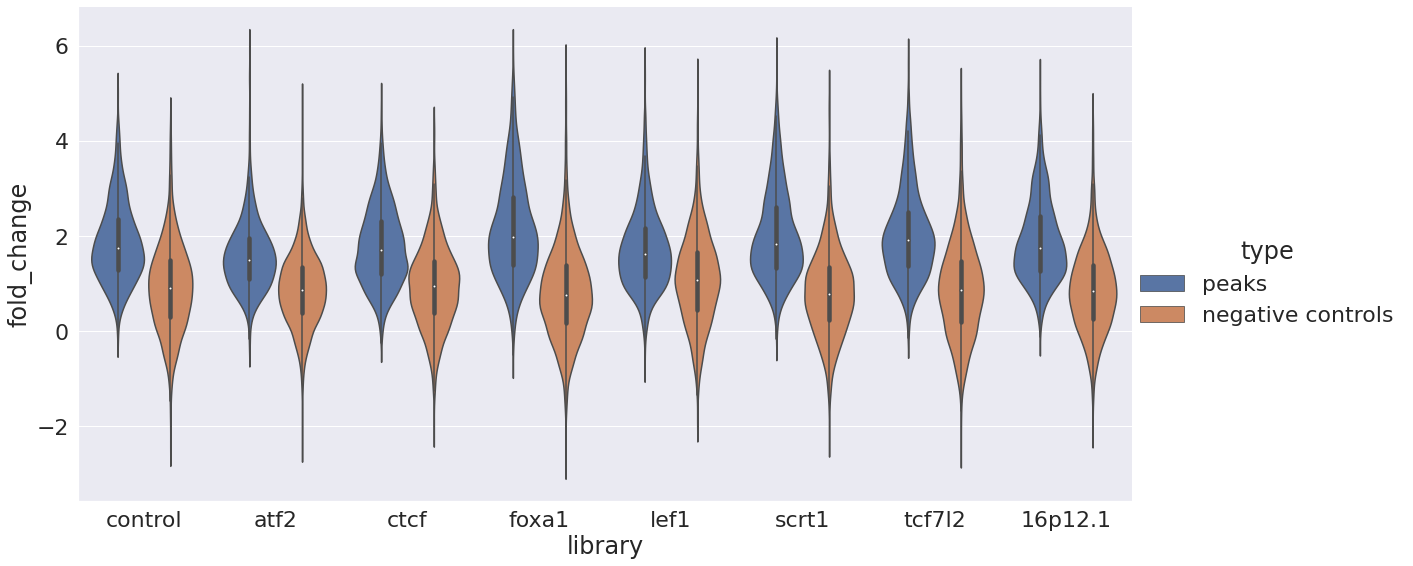

In [10]:
ax = sns.catplot(data= fc_df, hue="type", y="fold_change", x = "library", kind="violin", aspect=2, height=8)

In [15]:
ax.fig.savefig("/data5/deepro/starrseq/main_library/4_quality_control_peaks/data/figures/fold_change.svg")